In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
participant_file_names = []
participants = []
for i in range(1,16):
    participant_file_names.append(np.genfromtxt('%i.csv'%(i), delimiter=','))
    participants.append(np.genfromtxt('%i.csv'%(i), delimiter=','))


In [94]:
participants_train = participants[:2]

In [95]:
len(participants_train)

2

In [131]:
import pandas as pd
from scipy.stats import mode
n=0
p = 50
TIME_PERIODS = p
num_sensors = 1
x = []
y = []
 
for k in range(len(participants_train)):
    x_participant = pd.DataFrame(participants_train[k][:,1])
    x_participant = pd.concat([x_participant.shift(i) for i in range(p)], axis=1).dropna()
    y_participant = pd.DataFrame(participants_train[k][:,4])
    y_participant = y_participant[p-1:]
    x.append(x_participant)
    y.append(y_participant)


In [123]:
x = np.hstack(x)
x = np.expand_dims(x,2)
y = np.vstack(y)
y = y.flatten()

In [124]:
y.shape

(300404,)

In [125]:
x.shape # samples, timesteps, features

(300404, 50, 1)

In [112]:
# normalize to prevent weights in network going to 0
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x = scaler.fit_transform(x)

In [113]:
n_filters = 4
filter_size = 3
pool_size = 2

In [114]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
print(tf.__version__)


2.4.1


In [115]:
tf.keras.backend.clear_session()

In [116]:
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
y_binary = to_categorical(y)
tf.random.set_seed(1)

model = tf.keras.models.Sequential([
    #tf.keras.Input(input_shape=(TIME_PERIODS,num_sensors)),
    tf.keras.layers.Reshape((TIME_PERIODS, num_sensors), input_shape=(TIME_PERIODS,num_sensors)),
    BatchNormalization(),
    tf.keras.layers.Conv1D(n_filters, filter_size, activation='relu', 
                           padding='valid',input_shape=(TIME_PERIODS, num_sensors),
                          name='conv1'),
    tf.keras.layers.Conv1D(n_filters, filter_size, padding='valid', 
                           activation='relu', name='conv2'),
    tf.keras.layers.MaxPooling1D(pool_size, name='maxpool'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(y_binary.shape[1], activation='softmax')
])
 
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# adam = tf.keras.optimizers.Adam(lr=0.001, learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='adam')
# model.compile(optimizer='adam',
#               loss=loss_fn,
#               metrics=['accuracy'])

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 50, 1)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 1)             4         
_________________________________________________________________
conv1 (Conv1D)               (None, 48, 4)             16        
_________________________________________________________________
conv2 (Conv1D)               (None, 46, 4)             52        
_________________________________________________________________
maxpool (MaxPooling1D)       (None, 23, 4)             0         
_________________________________________________________________
flatten (Flatten)            (None, 92)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               9

# each conv1d with 'valid' padding will result in an output shape that is N - len(filter). The filter will slide along the input performing a dot product but will stop when there are not enough elements left at the end to align perfectly. This is in contrast to padding='same', where the input is zero-padded so that the length of the output is the same as the length of the input

### the flatten operation will collapse/concatenate the filter outputs into one long vector.

In [117]:
model.fit(x, y_binary,epochs=1, batch_size=64, verbose=1)

4694/4694 [==============================] - 17s 3ms/step - loss: 0.8779 - accuracy: 0.7085


# How can I obtain the output of an intermediate layer (feature extraction)?
https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

How can I obtain the output of an intermediate layer (feature extraction)?

In the Functional API and Sequential API, if a layer has been called exactly once, you can retrieve its output via layer.output and its input via layer.input. This enables you do quickly instantiate feature-extraction models

In [118]:
from tensorflow.keras.models import Model
 
layer_name = "conv1"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(name=layer_name).output)

# get the data into the correct shape for the model
x_predict = x[50000,:,:]
x_predict = np.expand_dims(x_predict,0)
intermediate_output = intermediate_layer_model.predict(x_predict)

Text(0.5, 1.0, 'Input to Network')

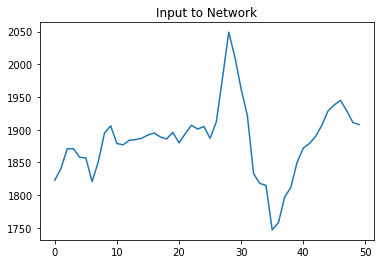

In [119]:
plt.plot(x_predict[0, :, 0])
plt.title('Input to Network')

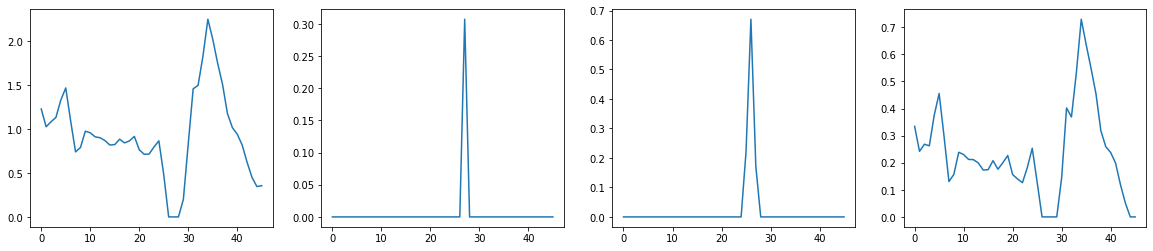

In [120]:
fig,ax=plt.subplots(1,n_filters,figsize=(20,4))
for i in range(0,n_filters):
    ax[i].plot(intermediate_output[0,1:-1,i])

# Get the output of the second conv layer

In [121]:
layer_name = "conv2"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(name=layer_name).output)


# get the data into the correct shape for the model
x_predict = x[50000,:,:]
x_predict = np.expand_dims(x_predict,0)
intermediate_output = intermediate_layer_model.predict(x_predict)

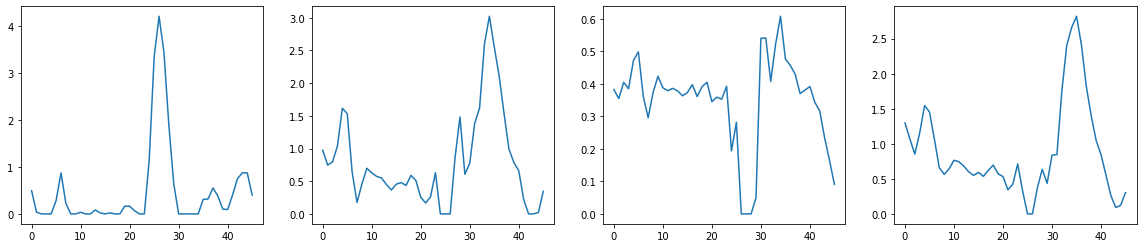

In [78]:
fig,ax=plt.subplots(1,n_filters,figsize=(20,4))
for i in range(0,n_filters):
    ax[i].plot(intermediate_output[0,1:-1,i])

# looks like it's smoothing the input

# What is a convolution doing?